In [1]:
pip install kaggle tensorflow keras scikit-learn matplotlib seaborn opencv-python streamlit


Note: you may need to restart the kernel to use updated packages.


In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 224
BATCH_SIZE = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

train_gen = datagen.flow_from_directory(
    "Garbage classification_1",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

val_gen = datagen.flow_from_directory(
    "garbage-dataset_1",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation"
)


Found 9387 images belonging to 13 classes.
Found 2851 images belonging to 13 classes.


In [2]:
print("Classes detected:", train_gen.class_indices)
print("Number of classes in generator:", train_gen.num_classes)


Classes detected: {'.ipynb_checkpoints': 0, 'battery': 1, 'biological': 2, 'brown-glass': 3, 'cardboard': 4, 'clothes': 5, 'green-glass': 6, 'metal': 7, 'paper': 8, 'plastic': 9, 'shoes': 10, 'trash': 11, 'white-glass': 12}
Number of classes in generator: 13


In [4]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # Freeze base layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(x)
preds = Dense(train_gen.num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=preds)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])




In [ ]:
train_ds = tf.data.Dataset.from_generator(
    lambda: train_gen,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, 224, 224, 3], [None, train_gen.num_classes])
)

val_ds = tf.data.Dataset.from_generator(
    lambda: val_gen,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, 224, 224, 3], [None, val_gen.num_classes])
)

# Optimize pipeline
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

history = model.fit(train_ds, validation_data=val_ds, epochs=10)


Epoch 1/10
    914/Unknown 785s 858ms/step - accuracy: 0.9065 - loss: 0.2845

90/90 ━━━━━━━━━━━━━━━━━━━━ 84s 934ms/step
                    precision    recall  f1-score   support

.ipynb_checkpoints       0.00      0.00      0.00         0
           battery       0.07      0.09      0.08       188
        biological       0.07      0.45      0.12       199
       brown-glass       0.05      0.03      0.04       121
         cardboard       0.00      0.00      0.00       316
           clothes       0.00      0.00      0.00       388
       green-glass       0.00      0.00      0.00       125
             metal       0.00      0.00      0.00       204
             paper       0.18      0.01      0.01       321
           plastic       0.12      0.11      0.11       335
             shoes       0.00      0.00      0.00       310
             trash       0.00      0.00      0.00       189
       white-glass       0.05      0.32      0.09       155

          accuracy                           0.07      2851
         macro avg       0.04      0.08      0.04      2

C:\Users\Bernietta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Bernietta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Bernietta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Bernietta\anaconda3\Lib\site-packages\skle

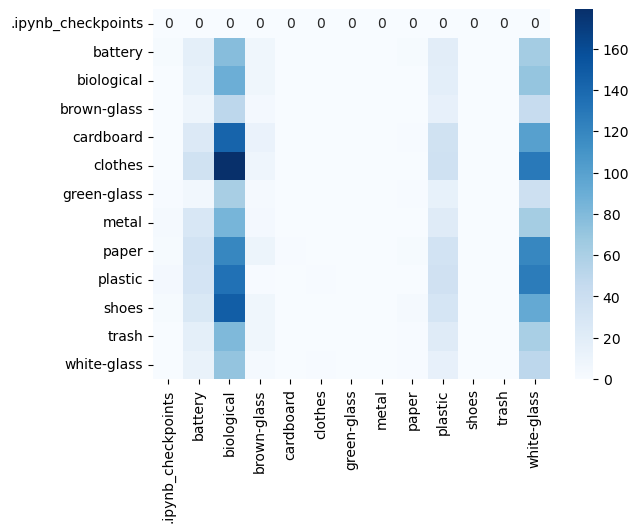

In [9]:
import math

# number of batches to cover the validation set
steps = math.ceil(val_gen.samples / val_gen.batch_size)

y_pred = model.predict(val_gen, steps=steps)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = val_gen.classes

print(classification_report(y_true, y_pred_classes, target_names=list(val_gen.class_indices.keys())))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(val_gen.class_indices.keys()),
            yticklabels=list(val_gen.class_indices.keys()))
plt.show()


In [7]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [8]:
from PIL import Image
import os

def clean_dataset(path):
    removed = 0
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.lower().endswith((".png", ".jpg", ".jpeg")):
                fpath = os.path.join(root, file)
                try:
                    img = Image.open(fpath)
                    img.verify()  # check for corruption
                except Exception as e:
                    print(f"Removing corrupted image: {fpath}")
                    os.remove(fpath)
                    removed += 1
    print(f"✅ Cleaned dataset, removed {removed} corrupted images")

# Run for both train and validation dirs
clean_dataset("dataset/train")
clean_dataset("dataset/validation")


✅ Cleaned dataset, removed 0 corrupted images
✅ Cleaned dataset, removed 0 corrupted images


In [11]:
model.save("garbage_classifier.keras")


In [ ]:
%%writefile Garbage_Image_Classification.py
import streamlit as st
import tensorflow as tf
import numpy as np
from PIL import Image

# Load trained model
model = tf.keras.models.load_model("garbage_classifier.h5")
class_names = ["cardboard", "glass", "metal", "paper", "plastic", "trash"]

st.title("♻️ RecycleVision - Garbage Classification")

uploaded_file = st.file_uploader("Upload an image of waste", type=["jpg","png","jpeg"])

if uploaded_file:
    image = Image.open(uploaded_file).resize((224,224))
    st.image(image, caption="Uploaded Image", use_container_width=True)

    img_array = np.array(image)/255.0
    img_array = np.expand_dims(img_array, axis=0)

    preds = model.predict(img_array)[0]
    top_class = class_names[np.argmax(preds)]
    confidence = np.max(preds)

    st.write(f"**Prediction:** {top_class} ({confidence*100:.2f}%)")

    # Show top-3 predictions
    top_indices = preds.argsort()[-3:][::-1]
    st.subheader("Top 3 Predictions")
    for i in top_indices:
        st.write(f"{class_names[i]}: {preds[i]*100:.2f}%")